# Recommender systems

## One of the most common uses of big data is to predict and suggest what users may want.  This allows Google to show you relevant ads or to suggest news in Google Now; Amazon to recommend relevant products; Netflix to recommend movies that you might like; or most recently, the famous **Weekly Dicovery** of Spotify.

## All these products are based on systems of recommendation: a information retrieval method to provide users with relevant, yet novel and diverse, information. 

## In this class we will use a pretty famous dataset based on movies ratings, 'MovieLens', to learn the basics of recommender systems. 

## Table of Contents (times are approximated)

1. [Getting and analysing some data (~1:30 h)](#data)
2. [Most popular movies (~30 min)](#popular)
3. [Metrics for recommender systems (~1.30h)](#metrics)
4. [Collaborative Filtering (~15 min)](#cf)  
   4.1 [Co-occurrence Matrix (~1.30h)](#copurchase)
   <br></br>
   4.2 [Memory-based CF (~1 h)](#memory-base)
   <br></br>
   4.3 [Model-based CF (~2 h)](#model-base)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import os
import time

<a id='data'></a>
## 1.1 Load data

We will use MovieLens dataset, which is one of the most common datasets used when implementing and testing recommender engines. This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies. 
* Each user has rated at least 20 movies. 
* Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens [website](https://movielens.org) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set.

You can download the dataset [here](http://files.grouplens.org/datasets/movielens/ml-100k.zip).

Take a look at the readme file!!!

In [2]:
data_root = 'ml-100k/'
readme = os.path.join(data_root, 'README')
!cat $readme

SUMMARY & USAGE LICENSE

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under th

In [3]:
columns = ['user_id','item_id','rating','timestamp']
datafile = os.path.join(data_root, 'u.data')
data = pd.read_csv(datafile, sep='\t', names=columns)
data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


*Pandas library is nothing alse than numpy under the hood (numpy with steroids, if you like). You can access the data (in matrix from) with he "values" attribute, e.g. data.values*

In [4]:
# access all rows, and first 3 columns 
data.values[:,:3]

array([[ 196,  242,    3],
       [ 186,  302,    3],
       [  22,  377,    1],
       ...,
       [ 276, 1090,    1],
       [  13,  225,    2],
       [  12,  203,    3]])

In [5]:
# access all collumns, and first 3 rows 
data.values[:3,:]

array([[      196,       242,         3, 881250949],
       [      186,       302,         3, 891717742],
       [       22,       377,         1, 878887116]])

In [6]:
# access first 10 rows
data.values[:10,:]

array([[      196,       242,         3, 881250949],
       [      186,       302,         3, 891717742],
       [       22,       377,         1, 878887116],
       [      244,        51,         2, 880606923],
       [      166,       346,         1, 886397596],
       [      298,       474,         4, 884182806],
       [      115,       265,         2, 881171488],
       [      253,       465,         5, 891628467],
       [      305,       451,         3, 886324817],
       [        6,        86,         3, 883603013]])

In [7]:
# access first column
data.values[:,0]

array([196, 186,  22, ..., 276,  13,  12])

In [8]:
# The attribute shape provides the shape of the matrix
data.values.shape

(100000, 4)

In [9]:
# Note that if we return the first column, we get a vector (of 100000 components)
data.values[:, 0].shape

(100000,)

In [10]:
# same with the first row (this time, we get a vector of 4 components)
data.values[0, :].shape

(4,)

In [11]:
# Number of users and items
n_users = data.user_id.unique().shape[0]
n_items = data.item_id.unique().shape[0]
#print("There are %s users and $s items" % (n_users, n_items))

## 1.2 A dictionary for movies and a search tool

In order to analyze the predicted recommendations, let's create a python dictonary that will allow us to translate any item id to the corresponding movie title. Also, let's write a small function that returns the ids of the movies containing some text.

The correspondance between titles and ids is stored in the u.item file

In [12]:
data_root = 'ml-100k/'
item_id_file = os.path.join(data_root, 'u.item')
!head $item_id_file

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0
6|Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)|01-Jan-1995||http://us.imdb.com/Title?Yao+a+yao+yao+dao+waipo+qiao+(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|0|0
7|Twelve Monkeys (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Twelve%20Monkeys%20(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|1|0|0|0
8|Babe (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Babe%20(1995)|0|0|0|0|1

*Simple reminder of dictionaries*

In [13]:
aux = {'hola':'que haces?',
      1:'235'}

In [14]:
# Access value of key='hola'
aux['hola']

'que haces?'

In [15]:
# create new key
aux['nuevo']='soy nuevo'
aux

{'hola': 'que haces?', 1: '235', 'nuevo': 'soy nuevo'}

In [16]:
# Update value of existing key
aux['nuevo'] = 'ya no lo soy'
aux

{'hola': 'que haces?', 1: '235', 'nuevo': 'ya no lo soy'}

In [17]:
# Create a dictionary for movie titles and ids
item_dict = {}
with io.open(item_id_file, 'rb') as f:
    for line in f.readlines():
        record = line.split(b'|')
        item_dict[int(record[0])] = str(record[1])
        
for record in data.values[:20]:
    print("User {u} viewed '{m} and gave a {r}".format(
        u = record[0],
        m = item_dict[record[1]],
        r=record[2]
    ))

User 196 viewed 'b'Kolya (1996)' and gave a 3
User 186 viewed 'b'L.A. Confidential (1997)' and gave a 3
User 22 viewed 'b'Heavyweights (1994)' and gave a 1
User 244 viewed 'b'Legends of the Fall (1994)' and gave a 2
User 166 viewed 'b'Jackie Brown (1997)' and gave a 1
User 298 viewed 'b'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)' and gave a 4
User 115 viewed 'b'Hunt for Red October, The (1990)' and gave a 2
User 253 viewed 'b'Jungle Book, The (1994)' and gave a 5
User 305 viewed 'b'Grease (1978)' and gave a 3
User 6 viewed 'b'Remains of the Day, The (1993)' and gave a 3
User 62 viewed 'b'Men in Black (1997)' and gave a 2
User 286 viewed 'b"Romy and Michele's High School Reunion (1997)" and gave a 5
User 200 viewed 'b'Star Trek: First Contact (1996)' and gave a 5
User 210 viewed 'b'To Wong Foo, Thanks for Everything! Julie Newmar (1995)' and gave a 3
User 224 viewed 'b'Batman Forever (1995)' and gave a 3
User 303 viewed 'b'Only You (1994)' and gave a 3
U

In [18]:
item_dict

{1: "b'Toy Story (1995)'",
 2: "b'GoldenEye (1995)'",
 3: "b'Four Rooms (1995)'",
 4: "b'Get Shorty (1995)'",
 5: "b'Copycat (1995)'",
 6: "b'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)'",
 7: "b'Twelve Monkeys (1995)'",
 8: "b'Babe (1995)'",
 9: "b'Dead Man Walking (1995)'",
 10: "b'Richard III (1995)'",
 11: "b'Seven (Se7en) (1995)'",
 12: "b'Usual Suspects, The (1995)'",
 13: "b'Mighty Aphrodite (1995)'",
 14: "b'Postino, Il (1994)'",
 15: 'b"Mr. Holland\'s Opus (1995)"',
 16: "b'French Twist (Gazon maudit) (1995)'",
 17: "b'From Dusk Till Dawn (1996)'",
 18: "b'White Balloon, The (1995)'",
 19: 'b"Antonia\'s Line (1995)"',
 20: "b'Angels and Insects (1995)'",
 21: "b'Muppet Treasure Island (1996)'",
 22: "b'Braveheart (1995)'",
 23: "b'Taxi Driver (1976)'",
 24: "b'Rumble in the Bronx (1995)'",
 25: "b'Birdcage, The (1996)'",
 26: "b'Brothers McMullen, The (1995)'",
 27: "b'Bad Boys (1995)'",
 28: "b'Apollo 13 (1995)'",
 29: "b'Batman Forever (1995)'",
 30: "b'Belle de jou

In [19]:
# We can use this dict to see the films a user has seen, for instance. 
for record in data.values[:20]:
    print("User {u} viewed '{m}' and gave a {r} rating".format(
        u=record[0], m=item_dict[record[1]], r=record[2]))    

User 196 viewed 'b'Kolya (1996)'' and gave a 3 rating
User 186 viewed 'b'L.A. Confidential (1997)'' and gave a 3 rating
User 22 viewed 'b'Heavyweights (1994)'' and gave a 1 rating
User 244 viewed 'b'Legends of the Fall (1994)'' and gave a 2 rating
User 166 viewed 'b'Jackie Brown (1997)'' and gave a 1 rating
User 298 viewed 'b'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'' and gave a 4 rating
User 115 viewed 'b'Hunt for Red October, The (1990)'' and gave a 2 rating
User 253 viewed 'b'Jungle Book, The (1994)'' and gave a 5 rating
User 305 viewed 'b'Grease (1978)'' and gave a 3 rating
User 6 viewed 'b'Remains of the Day, The (1993)'' and gave a 3 rating
User 62 viewed 'b'Men in Black (1997)'' and gave a 2 rating
User 286 viewed 'b"Romy and Michele's High School Reunion (1997)"' and gave a 5 rating
User 200 viewed 'b'Star Trek: First Contact (1996)'' and gave a 5 rating
User 210 viewed 'b'To Wong Foo, Thanks for Everything! Julie Newmar (1995)'' and gave a 3 

In [20]:
# Define a function that retrieves all the ids and titles for movies containing 'text' in its title
def returnItemId(text, ids):
    """
    :param text: string to be looked for in movies titles
    :param ids: dicttionary of {id:title}
    
    :return: a list of (id,title) if text found in titles, and an empty list otherwise.
    """
    # convert input text to lowercase
    text_ = text.lower()
    # find occurances
    search = [(k, v.lower().find(text_)) for k, v in ids.items()]
    # Get the IDs corresponding to the given text
    index = [k for k, v in search if v > -1]
    # Return a list with the id and the name
    out = []
    for i in index:
        out.append((i,ids[i]))
    
    #[(i, ids[i]) for i in index] no se que de listas muy pythonic
    
    return out

In [21]:
returnItemId('but', item_dict)

[(240, "b'Beavis and Butt-head Do America (1996)'"),
 (435, "b'Butch Cassidy and the Sundance Kid (1969)'"),
 (580,
  "b'Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)'"),
 (1401, "b'M. Butterfly (1993)'"),
 (1459, "b'Madame Butterfly (1995)'"),
 (1614, "b'Reluctant Debutante, The (1958)'"),
 (1621, "b'Butterfly Kiss (1995)'"),
 (1645, "b'Butcher Boy, The (1998)'"),
 (1650, "b'Butcher Boy, The (1998)'")]

## 1.3 Data consistency (always double check everything!!!)

In [22]:
# check whether titles are unique or not. They are not!!!
print(len(set(item_dict.keys())))
print(len(set(item_dict.values())))

1682
1664


### One work around: create another dict that consolidates ids with the same movie title

In [23]:
duplicates_item_dict = {}

for id_, name in item_dict.items():
    if name not in duplicates_item_dict:
        duplicates_item_dict[name]=[id_]
    else:
        duplicates_item_dict[name] = duplicates_item_dict[name] + [id_]

In [24]:
# Las claves en "duplicates_item_dict" son los nombres de las películas
# Los valores son una lista de los ids (que pueden ser uno solo, o varios)
for k, v in duplicates_item_dict.items():
    if len(v)>1:
        print(k,v)

b'Chasing Amy (1997)' [246, 268]
b'Kull the Conqueror (1997)' [266, 680]
b"Ulee's Gold (1997)" [297, 303]
b'Fly Away Home (1996)' [304, 500]
b'Ice Storm, The (1997)' [305, 865]
b'Deceiver (1997)' [309, 1606]
b'Desperate Measures (1998)' [329, 348]
b'Body Snatchers (1993)' [573, 670]
b'Substance of Fire, The (1996)' [711, 1658]
b'Money Talks (1997)' [876, 881]
b'That Darn Cat! (1997)' [878, 1003]
b'Hugo Pool (1997)' [1175, 1617]
b'Chairman of the Board (1998)' [1234, 1654]
b'Designated Mourner, The (1997)' [1256, 1257]
b'Hurricane Streets (1998)' [1395, 1607]
b'Sliding Doors (1998)' [1429, 1680]
b'Nightwatch (1997)' [1477, 1625]
b'Butcher Boy, The (1998)' [1645, 1650]


Create a dict where the key are the original ids, and the values are the unique one. 
We will use this dictionary to remove duplicates in a dataframe.

In [25]:
unique_id_item_dict = {}
for index, lista_id in enumerate(duplicates_item_dict.values()):
    for key in lista_id:
        unique_id_item_dict[key] = index

Create another dict mapping moving titles to this new unique id

In [26]:
unique_item_dict = { unique_id_item_dict[k]: v for k,v in item_dict.items()}

In [27]:
# check whether titles are unique or not. They are not!!!
print(len(set(unique_item_dict.keys())))
print(len(set(unique_item_dict.values())))

1664
1664


Now we can use our `returnItemId()` mehtod safely =)

In [28]:
returnItemId('but', unique_item_dict)

[(239, "b'Beavis and Butt-head Do America (1996)'"),
 (431, "b'Butch Cassidy and the Sundance Kid (1969)'"),
 (575,
  "b'Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)'"),
 (1390, "b'M. Butterfly (1993)'"),
 (1448, "b'Madame Butterfly (1995)'"),
 (1601, "b'Reluctant Debutante, The (1958)'"),
 (1607, "b'Butterfly Kiss (1995)'"),
 (1630, "b'Butcher Boy, The (1998)'")]

## 1.4 Train and test sets

GroupLens provides several splits of the dataset, so that we can check the goodness of our algorithms. See the README file for more  details. Here we will use one of such splits.

Please notice that we have to correct for the non-unique movie's id issue!!

In [29]:
!ls $data_root

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [30]:
trainfile = os.path.join(data_root, 'ua.base')
!head $trainfile

1	1	5	874965758
1	2	3	876893171
1	3	4	878542960
1	4	3	876893119
1	5	3	889751712
1	6	5	887431973
1	7	4	875071561
1	8	1	875072484
1	9	5	878543541
1	10	3	875693118


In [31]:
columns = ['user_id','item_id','rating','timestamp']
train = pd.read_csv(trainfile, sep='\t', names=columns)
print("There are {s1} users, {s2} items and {s3} pairs in the train set".format(
            s1=train.user_id.unique().shape[0],
            s2=train.item_id.unique().shape[0],
            s3=train.shape[0])
     )
train.head()

There are 943 users, 1680 items and 90570 pairs in the train set


,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [32]:
testfile = os.path.join(data_root, 'ua.test')
test = pd.read_csv(testfile, sep='\t', names=columns)
print("There are {s1} users, {s2} items and {s3} pairs in the train set".format(
            s1=test.user_id.unique().shape[0],
            s2=test.item_id.unique().shape[0],
            s3=test.shape[0])
     )
test.head()

There are 943 users, 1129 items and 9430 pairs in the train set


,user_id,item_id,rating,timestamp
0,1,20,4,887431883
1,1,33,4,878542699
2,1,61,4,878542420
3,1,117,3,874965739
4,1,155,2,878542201


### Correcting for non-unique movies id 

*Reminder of lambda functions in Python: is a way of calling short functions (1 line of code), without having to define the function in a separted cell.*

In [33]:
def func(x):
    return unique_id_item_dict[x]

In [34]:
# These three  lines of code are equivalent!!
test['item_id'].apply(lambda z: func(z)).head()
test['item_id'].apply(lambda z: unique_id_item_dict[z]).head()
test['item_id'].apply(func).head()

0     19
1     32
2     60
3    116
4    154
Name: item_id, dtype: int64

In [35]:
train['item_id'] = train['item_id'].apply(lambda pepito: unique_id_item_dict[pepito])
print('Now , there are {s1} unique items in the train set'.format(s1=train.item_id.unique().shape[0]))

Now , there are 1662 unique items in the train set


In [36]:
test['item_id'] = test['item_id'].apply(lambda pepito: unique_id_item_dict[pepito])
print('Now , there are {s1} unique items in the train set'.format(s1=test.item_id.unique().shape[0]))

Now , there are 1119 unique items in the train set


<a id='popular'></a>
## 2. Most popular movies

Recommending popular items is a simple, yet quite effective baseline for recommendation. Indeed, most RS suffer from a strong *popularity bias*, i.e. they tend to recommend popular items more frequently than they should -just because suggesting what is popular is effective!-. There is a lot of research  devote to understand this behaviour and to develop recipies to avoid it. 

Movies can be ranked according to different popularity metrics:
* Most rated movie (it is assumed that this is the most watched movie)
* Most positively rated movie (rating > 4.0)
* Highest rated movie

## 2.1 Most rated movie

In [37]:
# group the train dataset by item and count the number of users using Pandas
mostRated = train.groupby('item_id')['user_id'].count()
mostRated.head()

item_id
0    392
1    121
2     85
3    198
4     79
Name: user_id, dtype: int64

In [38]:
mostRatedSorted = mostRated.sort_values(ascending=False)
mostRatedSorted.head()

item_id
49     495
99     443
180    439
257    412
284    400
Name: user_id, dtype: int64

In [39]:
# Return a numpy array of [id, title, frequency]

# numpy requires knowledge of the data types. Since we have ids (integers) and titles (strings), 
# we will use a "parent" data type, np.object
mostRatedMovies = np.zeros(shape=(mostRatedSorted.shape[0], 3),
                          dtype = np.object)

for i, index in enumerate(mostRatedSorted.index):
    id_ = index
    freq_ = mostRatedSorted[id_]
    title_ =  unique_item_dict[id_]
    mostRatedMovies[i] = [id_, title_, freq_]
    
mostRatedMovies[:10, 1:]

array([["b'Star Wars (1977)'", 495],
       ["b'Fargo (1996)'", 443],
       ["b'Return of the Jedi (1983)'", 439],
       ["b'Contact (1997)'", 412],
       ["b'English Patient, The (1996)'", 400],
       ["b'Liar Liar (1997)'", 398],
       ["b'Toy Story (1995)'", 392],
       ["b'Scream (1996)'", 386],
       ["b'Independence Day (ID4) (1996)'", 384],
       ["b'Raiders of the Lost Ark (1981)'", 379]], dtype=object)

## 2.2 Most positively rated movie

In [40]:
# filter movies rated with rating >=4.0. Then group by item, count the number of users and sort in descending order.
positiveRated = train[train.rating>=4].groupby('item_id')['user_id'].count().sort_values(ascending=False)
positiveRated.head()

item_id
49     428
99     354
180    331
173    316
97     310
Name: user_id, dtype: int64

In [41]:
# Return a numpy array of [id, title, frequency]

# numpy requires knowledge of the data types. Since we have ids (integers) and titles (strings), 
# we will use a "parent" data type, np.object


In [42]:
positiveRatedMovies = np.zeros(shape=(positiveRated.shape[0],3),
                           dtype = np.object)

for i, index in enumerate(positiveRated.index):
    id_ = index
    freq_ = positiveRated[id_]
    title_ =  unique_item_dict[id_]
    positiveRatedMovies[i] = [id_, title_, freq_]
    
positiveRatedMovies[:10, 1:]

array([["b'Star Wars (1977)'", 428],
       ["b'Fargo (1996)'", 354],
       ["b'Return of the Jedi (1983)'", 331],
       ["b'Raiders of the Lost Ark (1981)'", 316],
       ["b'Silence of the Lambs, The (1991)'", 310],
       ["b'Godfather, The (1972)'", 298],
       ["b'Contact (1997)'", 276],
       ["b'Toy Story (1995)'", 275],
       ["b'Empire Strikes Back, The (1980)'", 264],
       ["b'Pulp Fiction (1994)'", 262]], dtype=object)

## 2.3 Highest mean rating movie

In [43]:
# obtaine the highest rated movies, with a minium number of users/ratings.
min_ratings = 50
# group the ratings by item and stack them in a list
listRatedMovies = train.groupby('item_id')['rating'].apply(list).reset_index()
listRatedMovies.head()
# filter movies with a minimum number of ratings
filteredListRatedMovies = listRatedMovies[ listRatedMovies.rating.apply(lambda x: len(x)>min_ratings)]
filteredListRatedMovies.head()

,item_id,rating
0,0,"[5, 4, 4, 4, 3, 1, 5, 5, 3, 5, 5, 5, 3, 5, 4, ..."
1,1,"[3, 3, 2, 3, 5, 1, 3, 3, 4, 4, 3, 2, 2, 3, 4, ..."
2,2,"[4, 2, 3, 4, 3, 2, 2, 1, 3, 3, 5, 3, 3, 3, 2, ..."
3,3,"[3, 5, 4, 5, 5, 5, 3, 5, 4, 2, 4, 4, 3, 3, 2, ..."
4,4,"[3, 1, 2, 3, 4, 4, 4, 3, 3, 2, 4, 3, 3, 4, 3, ..."


In [44]:
# obtain the mean of the list of rating per movie
meanMovies = filteredListRatedMovies.rating.apply(lambda x: np.mean(x)).sort_values(ascending=False)

In [45]:
meanMovies.head()

113    4.491525
404    4.480769
168    4.476636
315    4.475836
479    4.459821
Name: rating, dtype: float64

In [46]:
# Return a numpy array of [id, title, frequency]

# numpy requires knowledge of the data types. Since we have ids (integers) and titles (strings), 
# we will use a "parent" data type, np.object

meanRatedMovies = np.zeros(shape=(meanMovies.shape[0],3),
                           dtype = np.object)

for i, index in enumerate(meanMovies.index):
    id_ = index
    freq_ = meanMovies[id_]
    title_ =  unique_item_dict[id_]
    meanRatedMovies[i] = [id_, title_, freq_]
    
meanRatedMovies[:10, 1:]

array([["b'Wallace & Gromit: The Best of Aardman Animation (1996)'",
        4.491525423728813],
       ["b'Close Shave, A (1995)'", 4.480769230769231],
       ["b'Wrong Trousers, The (1993)'", 4.4766355140186915],
       ['b"Schindler\'s List (1993)"', 4.4758364312267656],
       ["b'Casablanca (1942)'", 4.459821428571429],
       ["b'Shawshank Redemption, The (1994)'", 4.457364341085271],
       ["b'Usual Suspects, The (1995)'", 4.386454183266932],
       ["b'Rear Window (1954)'", 4.374358974358974],
       ["b'Star Wars (1977)'", 4.365656565656566],
       ["b'12 Angry Men (1957)'", 4.327433628318584]], dtype=object)

<div class  = "alert alert-info"> 
** QUESTION **: set the value of *min_ratings* to 1, and re-run the cell. What happens now? Change this value
</div>

<div class  = "alert alert-info"> 
** QUESTION **: Which method is better?? How to measure a recommender system? 
</div>

<div class  = "alert alert-info"> 
** IMPORTANT QUESTION **: When might be useful to recommend popular items?
</div>

<a id='metrics'></a>
## 3. Metrics for recommender systems

As we have seen, even with the simplest solution --aka, recommending popular items-- is difficult to known which technique performs better. For this, there are a number of metrics that allow one to measure the goodness of a recommender system. 

Metrics can be design for measuring the relevance or accuracy of a recommendation, but they can be created for evaluating the novelty of a recommendation, or its diversity. 

For now, we will focus on relevance and accuracy. Several metrics exist:
* Accuracy: rmse, mae.
* Not ranked: Recall@k, Precision@k.
* With rank disccount: map@k, ndcg@k.
* With rank ordering: mean percentile rank.

We will be definiing some of them whitin this class. For the moment, let's talk about precision and recall.

## 3.1 Precision and recall

<img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg" alt="Precision and Recall in IR" style="float: right; width: 300px"/>

The concept of precision and recall comes form the world of information retrieval, have a look at the wikipedia:

https://en.wikipedia.org/wiki/Precision_and_recall

From this entry:

 * "**precision** (also called positive predictive value) is the fraction of retrieved instances that are relevant".
 * "**recall** (also known as sensitivity) is the fraction of relevant instances that are retrieved".

<br />
<div class  = "alert alert-info"> 
** QUESTION **: how do we know if some movie, unknown to the user, is relevant?
</div>

In other words, we cannot measure a false positive --something recommended that was not relevant--. In this regard, only recall-oriented metrics have an actual meaning in RS. Nonetheless, its common practice to define both metrics in RS as follows:
 
### $$\mathrm{recall}@N = \frac{\sum_{k=1}^N rel(k)}{\sum_{i\in \mathcal{I}_u} 1}$$
### $$\mathrm{precision}@N = \frac{\sum_{k=1}^N rel(k)}{N}$$

Here, $\mathcal{I}_u$ is the set of items adopted by user $u$, and $rel(k)$ is the relevance of a recommendation at position k in the list of recommendations. For ratings, the relevance could be defined as those movies rated above a certain threshold, e.g. $r_{ui}>4.0$. 

**Important to note: since precision is pretty much the same as recall in RS, metrcis usch as the *area under the ROC curve* doesn't have any meaning!!**

<div class = "alert alert-success">
As an example, consider a user that watched the following films:
<br /><br />
'Designated Mourner, The (1997)'
<br />
'Money Talks (1997)'
<br />
'Madame Butterfly (1995)'
<br />
'Batman Forever (1995)'
<br /><br />
The recommended items were: 
<br /><br />
'Batman (1989)' 
<br />
'Madame Butterfly (1995)'
<br /><br />
**What would be the recall and precision @1? and @2?**
<br />
**What do you think of recommending Batman? Is a bad or a good recommendation?**
</div>

Please notice that there isn't any actual difference between precision and recall in the context of RS: both measure the relevance of the recommendations, and tell nothing about items recommended that haven't been adopted by the user. Thus, it make sense to define a normalized recall as:

### $$\mathrm{recall}@N = \frac{\sum_{i=1}^N rel_i}{\mathrm{min}(N, \sum_{i\in \mathcal{I}_u} 1})$$

This way, results are normalized to 1 always.

<div class="alert alert-success">
**Exercise** Implement the above definition of recall
</div>

In [47]:
def recall_at_n(N, test, recommended, train=None):
    """
    :param N: number of recommendations
    :param test: list of movies seen by user in test
    :param train: list of movies seen by user in train. This has to be removed from the recommended list 
    :param recommended: list of movies recommended
    
    :return the recall
    """
    if train is not None:
        rec_true = []
        for r in recommended:
            if r not in train:
                rec_true.append(r)
    else:
        rec_true = recommended
        
    intersection = len(set(test) & set(rec_true[:N]))
    return intersection / float(np.minimum(N, len(test)))

In [48]:
seen = ['Designated Mourner, The (1997)', 'Money Talks (1997)', 'Madame Butterfly (1995)', 'Batman Forever (1995)']
recommended = ['Batman (1989)', 'Madame Butterfly (1995)']

In [49]:
recall_at_n(1, seen, recommended)

0.0

In [50]:
recall_at_n(2, seen, recommended)

0.5

In [51]:
# Check it's well normalized
print(recall_at_n(3, seen, recommended))
print(recall_at_n(10, seen, recommended))
print(recall_at_n(100, seen, recommended))

0.3333333333333333
0.25
0.25


### Now, use this implementation to measure the efficiency of the popularity baselines in the test set. Use the top-5 movies, for instance

In [52]:
mostRatedMovies[:5,1:]

array([["b'Star Wars (1977)'", 495],
       ["b'Fargo (1996)'", 443],
       ["b'Return of the Jedi (1983)'", 439],
       ["b'Contact (1997)'", 412],
       ["b'English Patient, The (1996)'", 400]], dtype=object)

In [53]:
positiveRatedMovies[:5,1:]

array([["b'Star Wars (1977)'", 428],
       ["b'Fargo (1996)'", 354],
       ["b'Return of the Jedi (1983)'", 331],
       ["b'Raiders of the Lost Ark (1981)'", 316],
       ["b'Silence of the Lambs, The (1991)'", 310]], dtype=object)

In [54]:
meanRatedMovies[:5,1:]

array([["b'Wallace & Gromit: The Best of Aardman Animation (1996)'",
        4.491525423728813],
       ["b'Close Shave, A (1995)'", 4.480769230769231],
       ["b'Wrong Trousers, The (1993)'", 4.4766355140186915],
       ['b"Schindler\'s List (1993)"', 4.4758364312267656],
       ["b'Casablanca (1942)'", 4.459821428571429]], dtype=object)

In [55]:
train.head()

,user_id,item_id,rating,timestamp
0,1,0,5,874965758
1,1,1,3,876893171
2,1,2,4,878542960
3,1,3,3,876893119
4,1,4,3,889751712


*Since `recall_at_n` takes both train and test list per user, we need to create a dataset with the list of movies seen in train and test*

Thus, get the list of movies per user in train and test, and join the two dataframes. For the join, use the pandas method `merge`.

In [56]:
# get movies in train per user. For this, group by user and get a list of item ids.
trainUserGroup = (train[train.rating >=4]
                 .groupby('user_id')['item_id']
                 .apply(list).reset_index())

trainUserGroup.head()

,user_id,item_id
0,1,"[0, 2, 5, 6, 8, 11, 12, 13, 14, 15, 17, 18, 21..."
1,2,"[0, 13, 24, 99, 110, 126, 236, 241, 254, 256, ..."
2,3,"[180, 259, 315, 317, 318, 324, 326, 337, 339, ..."
3,4,"[10, 257, 269, 298, 299, 321, 324, 326, 355, 3..."
4,5,"[23, 28, 39, 41, 49, 61, 69, 88, 94, 99, 100, ..."


In [57]:
# same with test data
testUserGroup = (test[test.rating >=4]
                 .groupby('user_id')['item_id']
                 .apply(list).reset_index())

testUserGroup.head()

,user_id,item_id
0,1,"[19, 32, 60, 159, 170, 201, 264]"
1,2,"[12, 49, 250, 290, 295]"
2,3,"[325, 328]"
3,4,"[49, 259, 286, 292, 295, 350, 353, 357]"
4,5,"[0, 16]"


In [58]:
# make the join
joined = pd.merge(trainUserGroup, testUserGroup, how='inner', on='user_id', suffixes=('_train', '_test'))

joined.head()

,user_id,item_id_train,item_id_test
0,1,"[0, 2, 5, 6, 8, 11, 12, 13, 14, 15, 17, 18, 21...","[19, 32, 60, 159, 170, 201, 264]"
1,2,"[0, 13, 24, 99, 110, 126, 236, 241, 254, 256, ...","[12, 49, 250, 290, 295]"
2,3,"[180, 259, 315, 317, 318, 324, 326, 337, 339, ...","[325, 328]"
3,4,"[10, 257, 269, 298, 299, 321, 324, 326, 355, 3...","[49, 259, 286, 292, 295, 350, 353, 357]"
4,5,"[23, 28, 39, 41, 49, 61, 69, 88, 94, 99, 100, ...","[0, 16]"


In [59]:
#joined['item_id_test'].apply(lambda x: x)
#joined.apply(lambda x: x[2], axis = 1)
#son analogos

In [60]:
# We can also access test values as follows:


In [61]:
joined.apply(lambda l: recall_at_n(N=15, test=l[2], train=l[1],
                                  recommended=mostRatedMovies[:,0]),axis=1).head()

0    0.142857
1    0.200000
2    0.000000
3    0.375000
4    0.500000
dtype: float64

In [62]:
topN = 30
recall_per_user = joined.apply(lambda l: recall_at_n(N=topN, test=l[2], train=l[1],
                                  recommended=mostRatedMovies[:,0]),axis=1)
recall_per_user.mean()

0.23399655008327372

In [63]:
topN = 30
recall_per_user = joined.apply(lambda l: recall_at_n(N=topN, test=l[2], train=l[1],
                                  recommended=meanRatedMovies[:,0]),axis=1)
recall_per_user.mean()

0.13298239352843227

In [64]:
topN = 30
recall_per_user = joined.apply(lambda l: recall_at_n(N=topN, test=l[2], train=l[1],
                                  recommended=positiveRatedMovies[:,0]),axis=1)
recall_per_user.mean()

0.23440569661126404

In [65]:
# This second method is easier if we want to access several columns at once, and operate over them.
# For instance, if we like to concatenate both train and test list, we will do:


In [66]:
# calculate the recall of the mostRatedMovies recommendation, for each user:


*As you can see, some users have a quite large recall (0.5), while for others is small (e.g, 0.14). Let's calculate the mean.*

In [67]:
# calculate the average recall across all users


## 3.2 Mean Averaged Precision (MAP) -- Advanced material

Previous metrics did not account for the ranking of the recommendation, i.e. the relative position of a movie within the sorted list of recommendations. **But orders matters!** Metrics like MAP, MRR or NDCG try to tackle down this problem. 

From the blog *http://fastml.com/what-you-wanted-to-know-about-mean-average-precision/*:

> Here’s another way to understand average precision. Wikipedia says AP is used to score document retrieval. You can think of it this way: you type something in Google and it shows you 10 results. It’s probably best if all of them were relevant. If only some are relevant, say five of them, then it’s much better if the relevant ones are shown first. It would be bad if first five were irrelevant and good ones only started from sixth, wouldn’t it? AP score reflects this.

Implementation taken from:

https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py



## Average Precision 

The Average Precision is definied as:

### $$\mathrm{AP}@N = \frac{\sum_{k=1}^N P(k) \times rel(k)}{\mathrm{min}(N, \sum_{i\in \mathcal{I}_u} 1)}$$

where $P(k)$ is the precision at cut-off in the item list, i.e. the ratio of the number of recommended items adopted, up to the position k, over the number k. Thus:

### $$\mathrm{AP}@N = \frac{\sum_{k=1}^N \left(\sum_{i=1}^k rel(i)\right)/k \times rel(k)}{\mathrm{min}(N, \sum_{i\in \mathcal{I}_u} 1)}$$



<div class = "alert alert-success">
Following the example above, consider a user that watched the following films:
<br /><br />
'Designated Mourner, The (1997)'
<br />
'Money Talks (1997)'
<br />
'Madame Butterfly (1995)'
<br />
'Batman Forever (1995)'
<br /><br />
The recommended items were: 
<br /><br />
'Batman (1989)' 
<br />
'Madame Butterfly (1995)'
<br /><br />

<div class = "alert alert-success">
**Calculate AP@1**
<br /><br />
First, *rel(1)=0*, because Batman was not viewed. Also, *P(1) = 0*. Thus, AP@1=0.
<br />
**Calculate AP@2**
<br /><br />
As before, *rel(1)=0*, so the first term does not contribute. For the second term, *rel(2)=1*, so that *P(2)=0.5*. The numerator is hence:
<br /><br />
$P(1)*rel(1)+P(2)*rel(2)=0*0+0.5*1$
<br /><br />
For the denominator, $N=2$ and $\sum_{i\in \mathcal{I}_u} 1)=4$, thus:
<br /><br />
AP@2 = 0.5/2 = 0.25
</div>

Let's now implement it =)

In [68]:
def apk(N, test, recommended, train=None):
    """
    Computes the average precision at N given recommendations.
    
    :param N: number of recommendations
    :param test: list of movies seen by user in test
    :param train: list of movies seen by user in train. This has to be removed from the recommended list 
    :param recommended: list of movies recommended
    
    :return The average precision at N over the test set
    """
    if train is not None:
        rec_true = []
        for r in recommended:
            if r not in train:
                rec_true.append(r)
    else:
        rec_true = recommended
    
    predicted = rec_true[:N]
    score = 0.0
    num_hits = 0.0
    
    for i, p in enumerate(predicted):
        if p in test and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(set(test)), N)

In [69]:
seen = ['Designated Mourner, The (1997)', 'Money Talks (1997)', 'Madame Butterfly (1995)', 'Batman Forever (1995)']
recommended = ['Madame Butterfly (1995)', 'Batman (1989)']

In [70]:
apk(1, seen, recommended)

1.0

In [71]:
apk(2, seen, recommended)

0.5

In [72]:
apk(3, seen, recommended)

0.3333333333333333

## MAP

Mean avergae precision is nothing else than the AP averaged across users ;)

Apply it to popularity baselines

In [73]:
topN = 1
predictions = mostRatedMovies[:,0]
m1 = joined.apply(lambda l: apk(topN, l[2], predictions, l[1]), axis=1).mean()
m1

0.12633832976445397

In [74]:
topN = 10 #se degrada bastante cuando nos alejamos de la cabeza
predictions = mostRatedMovies[:,0]
m1 = joined.apply(lambda l: apk(topN, l[2], predictions, l[1]), axis=1).mean()
m1

0.052704838974212964

In [75]:
topN = 10
predictions = meanRatedMovies[:,0]
m3 = joined.apply(lambda l: apk(topN, l[2], predictions, l[1]), axis=1).mean()
m3

0.012031699228981785

In [76]:
topN = 10
predictions = positiveRatedMovies[:,0]
m2 = joined.apply(lambda l: apk(topN, l[2], predictions, l[1]), axis=1).mean()
m2

0.05398091414970308

<img src="https://courses.edx.org/c4x/BerkeleyX/CS100.1x/asset/Collaborative_filtering.gif" alt="collaborative filtering" style="float: right; width: 300px"/>

## 4. Collaborative Filtering <a id='cf'></a>

Perhaps, one of the most succesful techniques for making personalized recommendations are the so called *collaborative filtering* (CF) algorithms. CF is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue X than to have the opinion on X of a person chosen randomly. 

The image at the right (from Wikipedia) shows an example of user's preference prediction using collaborative filtering. At first, people rate different items (like videos, images, games). After that, the system is making predictions about a user's rating for an item, which the user has not rated yet. These predictions are built upon the existing ratings of other users, who have similar ratings with the active user. For instance, in the image at the right the system has made a prediction, that the active user will not like the video.

In this part we will see three kinds of CF, of increasing complexity:

4.1 [CF with co-occurrence](#copurchase)

4.2 [Memory-based CF](#memory-base)

4.3 [Model-based CF](#model-base)

<a id='copurchase'></a>
## 4.1 Co-occurrence Matrix

The idea is to recommend movies similar to the movies already seen by a user. A measurement of similarity among items is obtained from the co-occurrence matrix. This is nothing else than the adjacency matrix of the graph of items created by users!!!

<table border="0" style="width:825px;border:0px;">
<tr>
    <td> 
        <img src="https://lucidworks.com/wp-content/uploads/2015/08/Les-Miserables-Co-Occurrence.png" style="width: 500px"/>
    </td>
    <td> 
        <img src="https://lucidworks.com/wp-content/uploads/2015/08/midnight-club-graph.png" style="width: 400px"/>
    </td>
</tr>
</table>


In [77]:
# create a dictionary of movies per user
moviesPerUser = (train[train.rating >= 4]
                 .groupby('user_id')['item_id']
                 .apply(np.array)
                 .to_dict())
moviesPerUser

{1: array([  0,   2,   5,   6,   8,  11,  12,  13,  14,  15,  17,  18,  21,
         22,  24,  27,  31,  38,  41,  42,  43,  44,  45,  46,  47,  49,
         50,  51,  54,  55,  56,  57,  58,  59,  63,  64,  65,  67,  71,
         74,  75,  76,  78,  79,  80,  81,  83,  85,  86,  87,  88,  89,
         90,  92,  94,  95,  97,  99, 105, 106, 107, 108, 110, 112, 113,
        114, 118, 120, 122, 123, 126, 127, 128, 131, 132, 133, 134, 136,
        143, 145, 149, 150, 151, 153, 155, 156, 160, 161, 162, 164, 165,
        167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 180, 181, 182,
        183, 184, 185, 186, 189, 190, 191, 192, 193, 194, 195, 196, 197,
        198, 202, 203, 205, 206, 207, 208, 209, 211, 213, 215, 220, 221,
        222, 223, 226, 227, 228, 229, 233, 234, 235, 237, 238, 240, 241,
        245, 247, 248, 249, 250, 252, 255, 256, 257, 266, 245, 267, 268]),
 2: array([  0,  13,  24,  99, 110, 126, 236, 241, 254, 256, 267, 270, 271,
        273, 274, 275, 277, 280, 281, 282, 

In [78]:
# calculate the number of items in train
n_items = len(unique_id_item_dict.keys())

In [79]:
# co-ocurrance matrix will have shape=[n_items,n_items]
coMatrix = np.zeros((n_items, n_items))
for user, movies in moviesPerUser.items():
    for m in movies:
        coMatrix[m, movies] += 1

In [80]:
# visualize the matrix
coMatrix

array([[275.,  26.,  17., ...,   0.,   0.,   0.],
       [ 26.,  46.,   4., ...,   0.,   0.,   0.],
       [ 17.,   4.,  32., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

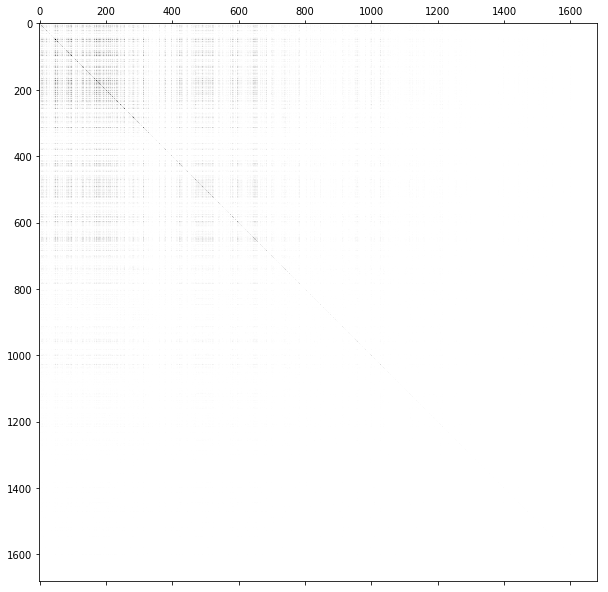

In [81]:
plt.matshow(coMatrix, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(10,10)
plt.show()

<div class="alert alert-success">
**QUESTION:** Can you think of a better way of visualizaing this matrix? Try to rescale it, or to rearrenge it follwoing some criteria (for instance, popularity!).
</div>

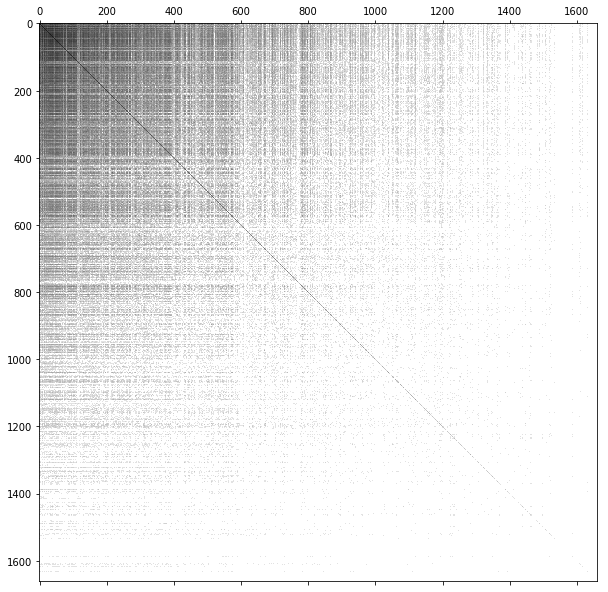

In [82]:
popular_indexing = mostRatedMovies[:,0].astype(np.int)
coMatrix_sorted = coMatrix[:, popular_indexing]
coMatrix_sorted_total = coMatrix_sorted[popular_indexing, :]
log_scale = np.log(coMatrix_sorted_total + 1.0) #para ver mejor, escalar ejemplo de 1000 y 3, pasa de 3 a 1, el +1 es por el log de 0 error
plt.matshow(log_scale, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(10,10)
plt.show()

### 4.1.1 Making predictions using the co-occurrence matrix

This kind of recommendations, based on item similarity, provide a measure of the closeness of one item to another. In order to make a recommendation for a user, we have to proceed as follows:

* First, define a function that returns the top-N closest items to a given one.
* Then, for a list of items adopted by a specific user, select the top-N items from the lists of top-N closest items to each adopted item.

In [83]:
def co_occurrance_similarity(item_id, coocurrance, ntop=10):
    """
    Returns the top-N most similar items to a given one, based on the coocurrance matrix
    
    :param item_id: id of input item
    :param cooccurrance: 2-dim numpy array with the co-occurance matrix
    :param ntop: number of items to be retrieved
    
    :return top-N most similar items to the given item_id
    """
    """
    # lo que yo he intentado
    items = np.argsort( coocurrance[item_id, :10] )
    freq = coocurrance[item_id, items]
    freq = freq[::-1]
    """
   
    similarItems = coocurrance[item_id, :]
    # return indeces of most similar items in descendign order
    mostSimilar = np.argsort(similarItems)[::-1]
    # remove the first element, as it is the item itslef
    mostSimilar = mostSimilar[1: ntop+1]
    # return a numpy array with the index (first column) and the value (second column) of the most similar items
    return np.stack((mostSimilar, similarItems[mostSimilar])).T

In [84]:
# First column are indices, while second one is the frequency of co-ocurrance
co_occurrance_similarity(49, coMatrix, 5)

array([[180., 276.],
       [173., 240.],
       [171., 224.],
       [ 97., 218.],
       [ 99., 205.]])

In [85]:
# Play with he movie ID!!!!
queryMovieId = 180 #Retorno del Jedy
Ntop = 5
print('For item {s1} top-{s2} recomendations are:'
      .format(
      s1=unique_item_dict[180],
      s2=Ntop))

similarItems = co_occurrance_similarity(queryMovieId, coMatrix, Ntop)
for r in similarItems:
    print(unique_item_dict[int(r[0])], r[1])

For item b'Return of the Jedi (1983)' top-5 recomendations are:
b'Star Wars (1977)' 276.0
b'Empire Strikes Back, The (1980)' 192.0
b'Raiders of the Lost Ark (1981)' 192.0
b'Silence of the Lambs, The (1991)' 167.0
b'Fargo (1996)' 163.0


Now, let use this function to make recommendations:

In [86]:
def co_occurrance_recommendation(items_id, cooccurrance, ntop=10):
    """
    Obtain the list of ntop recommendations based on a list of items (user history of views)
    
    :param items_id: list of items ids
    :param coocurrence: co-ocurrence matrix (numpy 2-dim array)
    :param ntop: top-K items to be retrieved
    
    :return list of ntop items recommended
    """
    # put together all the similar items and its value. For this, use np.vstack, wich stacks one array after 
    list_sim_items = np.vstack([co_occurrance_similarity(id_, cooccurrance, ntop)
                               for id_ in items_id])
    # another (row wise)
    # Group by id and take the maximum frequency to remove duplicates
    largest_freq = pd.DataFrame(list_sim_items,
                               columns=['id','freq']) \
        .groupby('id') \
        .agg(max) \
        .reset_index()
    # sort by value in descending order
    sorted_list = largest_freq.sort_values(by='freq', ascending=False)
    # get the top N
    out = sorted_list.values[:ntop,0]
    return out

In [87]:
# get users in train with their movies
trainUsersGrouped = train[train.rating >=4] \
    .groupby('user_id')['item_id'].apply(list).reset_index()
trainUsersGrouped.head()

,user_id,item_id
0,1,"[0, 2, 5, 6, 8, 11, 12, 13, 14, 15, 17, 18, 21..."
1,2,"[0, 13, 24, 99, 110, 126, 236, 241, 254, 256, ..."
2,3,"[180, 259, 315, 317, 318, 324, 326, 337, 339, ..."
3,4,"[10, 257, 269, 298, 299, 321, 324, 326, 355, 3..."
4,5,"[23, 28, 39, 41, 49, 61, 69, 88, 94, 99, 100, ..."


In [88]:
# Get the recommendations for all users using the apply method
Ntop = 5
predictions = trainUsersGrouped.item_id.apply(lambda x: co_occurrance_recommendation(x, coMatrix, Ntop))
predictions.head()

0    [49.0, 180.0, 173.0, 171.0, 97.0]
1     [49.0, 126.0, 99.0, 97.0, 180.0]
2     [49.0, 171.0, 173.0, 97.0, 99.0]
3     [49.0, 180.0, 99.0, 97.0, 173.0]
4    [180.0, 49.0, 173.0, 171.0, 97.0]
Name: item_id, dtype: object

**Note that, unlike previous popularity based models, the recommendation is now (slightly) different from one user to another**

In [89]:
testUsersGrouped = test[test.rating >=4] \
    .groupby('user_id')['item_id'].apply(list).reset_index()

In [90]:
for (seen, recom) in zip(testUsersGrouped.values[:3, 1], predictions[:3]):
    print("*"*6)
    print("Seen items: ")
    print([unique_item_dict[i] for i in seen])
    print("Recommended items: ")
    print([unique_item_dict[i] for i in recom])

******
Seen items: 
["b'Angels and Insects (1995)'", "b'Desperado (1995)'", "b'Three Colors: White (1994)'", "b'Glengarry Glen Ross (1992)'", "b'Delicatessen (1991)'", "b'Groundhog Day (1993)'", "b'Hunt for Red October, The (1990)'"]
Recommended items: 
["b'Star Wars (1977)'", "b'Return of the Jedi (1983)'", "b'Raiders of the Lost Ark (1981)'", "b'Empire Strikes Back, The (1980)'", "b'Silence of the Lambs, The (1991)'"]
******
Seen items: 
["b'Mighty Aphrodite (1995)'", "b'Star Wars (1977)'", "b'Shall We Dance? (1996)'", "b'Rosewood (1997)'", 'b"Ulee\'s Gold (1997)"']
Recommended items: 
["b'Star Wars (1977)'", "b'Godfather, The (1972)'", "b'Fargo (1996)'", "b'Silence of the Lambs, The (1991)'", "b'Return of the Jedi (1983)'"]
******
Seen items: 
["b'Conspiracy Theory (1997)'", "b'Edge, The (1997)'"]
Recommended items: 
["b'Star Wars (1977)'", "b'Empire Strikes Back, The (1980)'", "b'Raiders of the Lost Ark (1981)'", "b'Silence of the Lambs, The (1991)'", "b'Fargo (1996)'"]


### Evalute the recommendation

For this, first add a column to `trainUserGrouped` with the predictions using the apply procedure above.
Next, join this dataframe with the test dataframe, and get the `recall_at_n`

In [91]:
# add a prediction column to train
topN = 30
trainUsersGrouped['prediction'] = trainUsersGrouped\
    .item_id.apply(lambda x: co_occurrance_recommendation(x, coMatrix, topN))
trainUsersGrouped.head()

,user_id,item_id,prediction
0,1,"[0, 2, 5, 6, 8, 11, 12, 13, 14, 15, 17, 18, 21...","[180.0, 49.0, 173.0, 171.0, 97.0, 99.0, 126.0,..."
1,2,"[0, 13, 24, 99, 110, 126, 236, 241, 254, 256, ...","[49.0, 126.0, 99.0, 97.0, 180.0, 173.0, 55.0, ..."
2,3,"[180, 259, 315, 317, 318, 324, 326, 337, 339, ...","[49.0, 171.0, 173.0, 97.0, 99.0, 0.0, 126.0, 2..."
3,4,"[10, 257, 269, 298, 299, 321, 324, 326, 355, 3...","[49.0, 180.0, 99.0, 97.0, 173.0, 55.0, 6.0, 12..."
4,5,"[23, 28, 39, 41, 49, 61, 69, 88, 94, 99, 100, ...","[180.0, 49.0, 173.0, 171.0, 97.0, 99.0, 126.0,..."


In [92]:
# Join the df with train and predictions with the test df
joined = pd.merge(trainUsersGrouped, testUsersGrouped,
                 how='inner', on='user_id',
                 suffixes=('_train','_test'))
joined.head()

,user_id,item_id_train,prediction,item_id_test
0,1,"[0, 2, 5, 6, 8, 11, 12, 13, 14, 15, 17, 18, 21...","[180.0, 49.0, 173.0, 171.0, 97.0, 99.0, 126.0,...","[19, 32, 60, 159, 170, 201, 264]"
1,2,"[0, 13, 24, 99, 110, 126, 236, 241, 254, 256, ...","[49.0, 126.0, 99.0, 97.0, 180.0, 173.0, 55.0, ...","[12, 49, 250, 290, 295]"
2,3,"[180, 259, 315, 317, 318, 324, 326, 337, 339, ...","[49.0, 171.0, 173.0, 97.0, 99.0, 0.0, 126.0, 2...","[325, 328]"
3,4,"[10, 257, 269, 298, 299, 321, 324, 326, 355, 3...","[49.0, 180.0, 99.0, 97.0, 173.0, 55.0, 6.0, 12...","[49, 259, 286, 292, 295, 350, 353, 357]"
4,5,"[23, 28, 39, 41, 49, 61, 69, 88, 94, 99, 100, ...","[180.0, 49.0, 173.0, 171.0, 97.0, 99.0, 126.0,...","[0, 16]"


In [93]:
# Uncomment the following line to see the help of method recall_at_n
recall = joined.apply(lambda l:
                     recall_at_n(N=topN, test=l[3],
                                train=l[1],
                                recommended=l[2]), axis=1).mean()

print('recall@{s} = {s1}'.format(s=topN, s1=recall))
# recall_at_n??

recall@30 = 0.19041203562081502


In [94]:
# average recall across all users
recall = joined.apply(lambda l:
                      recall_at_n(N=topN, test=l[3],
                                 train=l[1],
                                 recommended=positiveRatedMovies[:, 0]),
                      axis=1).mean()

recall

0.23440569661126404

In [95]:
# average recall across all users


In [96]:
# do the same for different top k values. It might be convenient to define a function!
def evaluate_recall(topN, trainGrouped, testGrouped, coMatrix, popularity_baseline):
    # add a prediction column to train
    trainGrouped['prediction'] =  trainGrouped.item_id\
        .apply(lambda x: co_occurrance_recommendation(x, coMatrix, topN))
    # join with test data
    joined = pd.merge(trainGrouped, testGrouped, how='inner', on='user_id', suffixes=('_train','_test'))
    # calculate average recall
    recall = joined.apply(lambda l:
                         recall_at_n(N=topN,
                                    test=l[3],
                                    train=l[1],
                                    recommended=l[2]),
                         axis=1).mean()
    print('Co-occurence model: recall@{s1} = {s2}'.format(s1=topN, s2=recall))
    # calculate average recall for the baseline
    recall_baseline = joined.apply(lambda l:
                         recall_at_n(N=topN,
                                    test=l[3],
                                    train=l[1],
                                    recommended=popularity_baseline),
                         axis=1).mean()
    print('Baseline model: recall@{s1} = {s2}'.format(s1=topN, s2=recall_baseline))
    return recall, recall_baseline

In [97]:
for k in [3,10,30,50,100]:
    evaluate_recall(k, trainUsersGrouped, testUsersGrouped, coMatrix, positiveRatedMovies[:, 0]);

Co-occurence model: recall@3 = 0.06763026409707364
Baseline model: recall@3 = 0.10189150606709474
Co-occurence model: recall@10 = 0.09608612895550807
Baseline model: recall@10 = 0.1179969239658749
Co-occurence model: recall@30 = 0.19041203562081502
Baseline model: recall@30 = 0.23440569661126404
Co-occurence model: recall@50 = 0.269241358213521
Baseline model: recall@50 = 0.32128794058665533
Co-occurence model: recall@100 = 0.41662078107474243
Baseline model: recall@100 = 0.44873347268957536


*Do the same analysis for the map metric*

In [98]:
# Uncomment the following line to see the help of method apk

# apk??

In [99]:
def evaluate_map(topN, trainGrouped, testGrouped, coMatrix, popularity_baseline):
    # add a prediction column to train
    trainGrouped['prediction'] =  trainGrouped.item_id\
        .apply(lambda x: co_occurrance_recommendation(x, coMatrix, topN))
    # join with test data
    joined = pd.merge(trainGrouped, testGrouped, how='inner', on='user_id', suffixes=('_train','_test'))
    # calculate average recall
    map_ = joined.apply(lambda l:
                                 apk(N=topN,
                                     test=l[3],
                                     train=l[1],
                                     recommended=l[2]),
                         axis=1).mean()
    print('Co-occurence apk: apk-k={s1} = {s2}'.format(s1=topN, s2=map_))
    # calculate average recall for the baseline
    map_baseline = joined.apply(lambda l:
                                          apk(N=topN,
                                              test=l[3],
                                              train=l[1],
                                              recommended=popularity_baseline),
                         axis=1).mean()
    print('Baseline apk: apk-k={s1} = {s2}'.format(s1=topN, s2=map_baseline))
    return map_, map_baseline

In [100]:
for k in [3,10,30,50,100]:
    evaluate_map(k, trainUsersGrouped, testUsersGrouped, coMatrix, positiveRatedMovies[:, 0]);

Co-occurence apk: apk-k=3 = 0.057786105162978885
Baseline apk: apk-k=3 = 0.07512491077801574
Co-occurence apk: apk-k=10 = 0.05361445339496742
Baseline apk: apk-k=10 = 0.05398091414970308
Co-occurence apk: apk-k=30 = 0.06839175856987827
Baseline apk: apk-k=30 = 0.06555409458538326
Co-occurence apk: apk-k=50 = 0.07562035121067741
Baseline apk: apk-k=50 = 0.07101617616770885
Co-occurence apk: apk-k=100 = 0.08340386789442279
Baseline apk: apk-k=100 = 0.07661168765053242


<div class = "alert alert-info">
Compare this results to those obtained with the popularity model. Was it so bad?
</div>

Some comments:
* The dataset we are using here is very simple. Indeed, you can see that the popularity baseline achieves quite decent metric values. This won't happen in a real world dataset! The reason it happens here is because the dataset is quite small, and quite biased towards popular items. 

* Recall does not account for the order of the recommendation, while map does. This explains why the co-occurrance model performs better after the first 10 recommendations in terms of map (ordering), while recall values are always better for the popularity based model.  


### 4.1.2 Oher distances

So far, we have defined the *closeness* of two items as the number of users shared. However, it would make make sense to define it relative the total number of users that have watch a movie. This can be done with the [Jaccard similarity index](https://en.wikipedia.org/wiki/Jaccard_index):

$$J(i,j)=\frac{|i\cap j|}{|i|+|j|-|i\cap j|}\in [0,1]$$


<div class = "alert alert-success">
Build the Jaccard similarity matrix from the co-occurrance matrix. Notice that $CoM(i,j) = |i\cap j|$ and $CoM(k,k) = |k|$. In addition, if both $|i|=0$ and $|j|=0$, the similarity is defined as 1 (this is a convention).
</div>

In [101]:
# note that the diagonal of CoMatrix provides the number of visualizations of each movie
np.diag(coMatrix)

array([275.,  46.,  32., ...,   0.,   0.,   0.])

In [102]:
# Jaccard similarity matrix
jaccard = np.zeros((n_items,n_items))
for i, row in enumerate(coMatrix):
    if row[i] != 0:
        jaccard[i,:] = row / (row[i]+ np.diag(coMatrix) - row)
    else:
        for j in np.arange(n_items):
            if coMatrix[j,j]==0:
                jaccard[i,j]=1.0
            else:
                jaccard[i,j]= 0.0

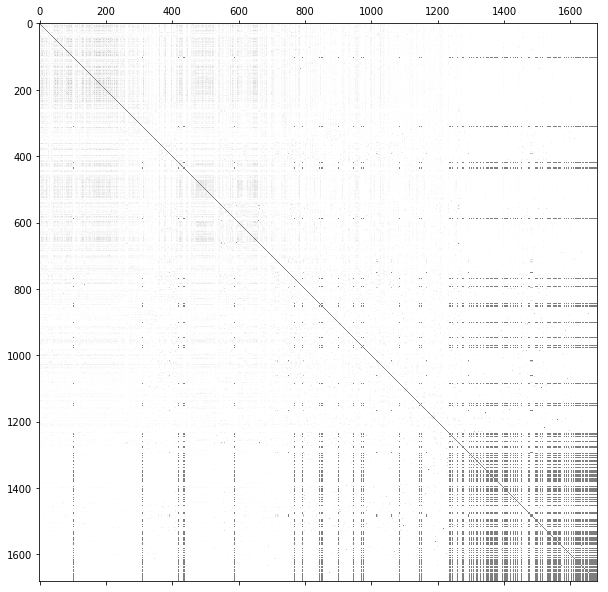

In [103]:
# visualize the matrix
plt.matshow(jaccard, fignum=1000, cmap=plt.cm.binary)
plt.gcf().set_size_inches(10, 10)
plt.show()

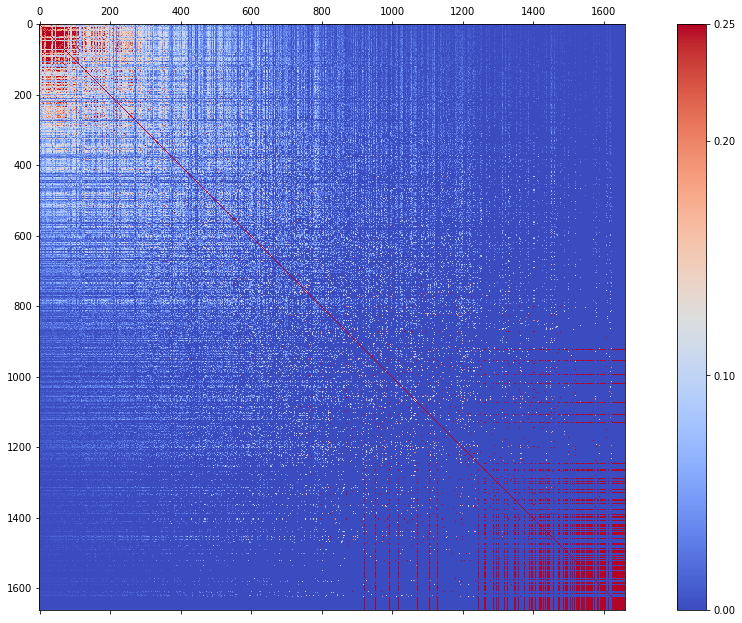

In [104]:
popular_indexing = mostRatedMovies[:,0].astype(np.int)
jaccard_sorted = jaccard[:, popular_indexing]
jaccard_sorted_total = jaccard_sorted[popular_indexing, :]

cax = plt.matshow(jaccard_sorted_total, fignum=1000, cmap=plt.cm.coolwarm)
plt.gcf().colorbar(cax, ticks=[0, 0.1, 0.2, 0.25])
plt.clim(0, 0.25)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [105]:
# let's print out the first Ntop recommendations
# Play with he movie ID!!!!
queryMovieId = 40
Ntop = 5
print('For item {s1} top-{s2} recomendations are:'
      .format(
      s1=unique_item_dict[180],
      s2=Ntop))

similarItems = co_occurrance_similarity(queryMovieId, jaccard, Ntop)
for r in similarItems:
    print(unique_item_dict[int(r[0])], r[1])

For item b'Return of the Jedi (1983)' top-5 recomendations are:
b'Young Guns II (1990)' 0.2222222222222222
b'Tommy Boy (1995)' 0.20689655172413793
b'Quick and the Dead, The (1995)' 0.19230769230769232
b'Dumb & Dumber (1994)' 0.18181818181818182
b'Ace Ventura: Pet Detective (1994)' 0.15217391304347827


In [106]:
# Calculate the predictoins with Jaccard
Ntop = 10
predictions = trainUsersGrouped.item_id \
    .apply(lambda x: co_occurrance_recommendation(x, jaccard, Ntop))
predictions.head()

0    [49.0, 180.0, 164.0, 165.0, 182.0, 175.0, 171....
1    [312.0, 49.0, 126.0, 99.0, 186.0, 281.0, 273.0...
2    [49.0, 171.0, 173.0, 63.0, 21.0, 209.0, 419.0,...
3    [1600.0, 876.0, 355.0, 356.0, 11.0, 21.0, 1599...
4    [49.0, 180.0, 175.0, 173.0, 171.0, 194.0, 209....
Name: item_id, dtype: object

In [107]:
Ntop = 10
predictions = testUsersGrouped.item_id \
    .apply(lambda x: co_occurrance_recommendation(x, jaccard, Ntop))

In [108]:
for (seen, recom) in zip(testUsersGrouped.values[:3, 1], predictions[:3]):
    print("*"*6)
    print("Seen items: ")
    print([unique_item_dict[i] for i in seen])
    print("Recommended items: ")
    print([unique_item_dict[i] for i in recom])

******
Seen items: 
["b'Angels and Insects (1995)'", "b'Desperado (1995)'", "b'Three Colors: White (1994)'", "b'Glengarry Glen Ross (1992)'", "b'Delicatessen (1991)'", "b'Groundhog Day (1993)'", "b'Hunt for Red October, The (1990)'"]
Recommended items: 
["b'Three Colors: Blue (1993)'", "b'Three Colors: Red (1994)'", "b'Dave (1993)'", "b'Fugitive, The (1993)'", "b'Back to the Future (1985)'", "b'Empire Strikes Back, The (1980)'", "b'Terminator, The (1984)'", "b'Raiders of the Lost Ark (1981)'", "b'Forrest Gump (1994)'", "b'Braveheart (1995)'"]
******
Seen items: 
["b'Mighty Aphrodite (1995)'", "b'Star Wars (1977)'", "b'Shall We Dance? (1996)'", "b'Rosewood (1997)'", 'b"Ulee\'s Gold (1997)"']
Recommended items: 
["b'Return of the Jedi (1983)'", "b'Empire Strikes Back, The (1980)'", "b'Raiders of the Lost Ark (1981)'", "b'Silence of the Lambs, The (1991)'", "b'Princess Bride, The (1987)'", "b'Indiana Jones and the Last Crusade (1989)'", "b'Godfather, The (1972)'", "b'Fugitive, The (1993)'

### Evaluate the recommendations

In [109]:
for k in [3,10,30,50,100]:
    evaluate_recall(k, trainUsersGrouped, testUsersGrouped, jaccard, positiveRatedMovies[:, 0]);

Co-occurence model: recall@3 = 0.08012134189864385
Baseline model: recall@3 = 0.10189150606709474
Co-occurence model: recall@10 = 0.09769127493966918
Baseline model: recall@10 = 0.1179969239658749
Co-occurence model: recall@30 = 0.2060365045375752
Baseline model: recall@30 = 0.23440569661126404
Co-occurence model: recall@50 = 0.291348866455933
Baseline model: recall@50 = 0.32128794058665533
Co-occurence model: recall@100 = 0.4544670473471331
Baseline model: recall@100 = 0.44873347268957536


In [110]:
for k in [3,10,30,50,100]:
    evaluate_map(k, trainUsersGrouped, testUsersGrouped, jaccard, positiveRatedMovies[:, 0]);

Co-occurence apk: apk-k=3 = 0.06468593861527491
Baseline apk: apk-k=3 = 0.07512491077801574
Co-occurence apk: apk-k=10 = 0.055498397848313834
Baseline apk: apk-k=10 = 0.05398091414970308
Co-occurence apk: apk-k=30 = 0.0729465486761509
Baseline apk: apk-k=30 = 0.06555409458538326
Co-occurence apk: apk-k=50 = 0.08027316901140474
Baseline apk: apk-k=50 = 0.07101617616770885
Co-occurence apk: apk-k=100 = 0.0901186783991052
Baseline apk: apk-k=100 = 0.07661168765053242


**Note that the co-occurance model with Jaccard distance works better than the one counting occurances. Indeed, it has higher recall values than the popularity model for large top-N**

<a id='memory-base'></a>
## 4.2. Memory-Based Collaborative Filtering (CF)

Although the methods developed so far return a list of recommended items, they cannot be used to make an actual prediction regarding the rating. A quite different approach would be to calculate the unknown rating, $r_{ui}$, as the averaged of some other ratings, thta are somehow close to either the user or the item in question. 

Thus, one approach is to take

### $$r_{u,i} = \frac{1}{K}\sum_{j\in\mathcal{I}'} \mathrm{sim}(i,j) r_{u,j},$$

where items $j\in\mathcal{I}'$ are taken from the set of $K$ closest items to $i$, or from the whole dataset. This is known as **item-item collaborative filtering**, and can be interpreted as *“users who liked this movie also liked …”*. See Amazon famous patent: https://www.google.com/patents/US7113917. Basically, this technique will take an item, find users who liked that item, and find other items that those users or similar users also liked. 

Similarly, one can define a **user-user filtering** where predictions are made as

### $$r_{u,i} = \frac{1}{K} \sum_{v\in\mathcal{U}'} \mathrm{sim}(u,v) r_{v,i}.$$

<img src="https://soundsuggest.files.wordpress.com/2013/06/utility_matrix.png" alt="utility matrix" style="float: right; width: 400px"/>

In this case, the recommendation would be more like *“users who are similar to you also liked …”*. Both techniques are part of the broad familiy of **Memory-Based Collaborative Filtering** approaches, or neighborhood-based algorithms.

The similarity among users or items can be calculated in a variety of forms: Pearson's correlation, cosine distance, etc. Here we will use the cosine distance. For this, we will first create the utility user-item matrix. 

The utility matrix is a dense representation of the user-item intearction. We have been using the *long* format, where missing entries are obviated; now, we will use the *wide* format, i.e. the matrix representation (see the figure on the right). 

<br></br>
<div class = "alert alert-info">
** NOTE **: Long and wide formats have its benefits and drawbacks. Can you think of some of them?
</div>

In [111]:
train.values[:, 0:3]

array([[   1,    0,    5],
       [   1,    1,    3],
       [   1,    2,    4],
       ...,
       [ 943, 1178,    3],
       [ 943, 1218,    3],
       [ 943, 1319,    3]])

Put the train and test datasets in wide format (i.e., like a matrix)

In [112]:
# utility matrix training
uMatrixTraining = np.zeros((n_users, n_items))
for row in train.values[:, 0:3]:
    user = row[0] - 1
    item = row[1]
    rating = row[2]
    uMatrixTraining[user, item] = rating    

In [113]:
# utility matrix testing
uMatrixTesting = np.zeros((n_users, n_items))
for row in train.values[:, 0:3]:
    user = row[0] - 1
    item = row[1]
    rating = row[2]
    uMatrixTesting[user, item] = rating

In [114]:
uMatrixTraining.shape

(943, 1682)

In [115]:
uMatrixTraining[0, :]

array([5., 3., 4., ..., 0., 0., 0.])

In [116]:
### Define a similarity measure: cosine similarity

### $$\mathrm{sim}({\bf a},{\bf b})=\frac{{\bf a}\cdot{\bf b}}{\sqrt{{\bf a}\cdot{\bf a}}\sqrt{{\bf  b}\cdot{\bf b}}}$$

In [117]:
def cosineSimilarity(ratings, kind='user', epsilon=1e-9):
    """
    Calculate the cosine distance along the row (columns) of a matrix for users (items)
    
    :param ratings: a n_user X n_items matrix
    :param kind: string indicating whether we are in mode 'user' or 'item'
    :param epsilon: a small value to avoid dividing by zero (optional, defaults to 1e-9)
    
    :return a square matrix with the similarities
    """
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
        
    norms = np.array(np.sqrt(np.diagonal(sim)))
    return sim/ norms / norms.T

In [118]:
m = cosineSimilarity(uMatrixTraining, 'item')

In [119]:
m.shape

(1682, 1682)

### 4.2.1. User-user CF

*“Users who are similar to you also liked …”*

### $$r_{u,i} = \frac{1}{K} \sum_{v\in\mathcal{U}'} \mathrm{sim}(u,v) r_{v,i}.$$
Consider user $x$:

1. Find other users whose ratings are “similar” to $x$’s ratings, i.e. calculate the similarity among users
2. Estimate missing ratings based on ratings of similar users

In [120]:
# we use cosine similarity
userSimilarity = cosineSimilarity(uMatrixTraining, kind='user')

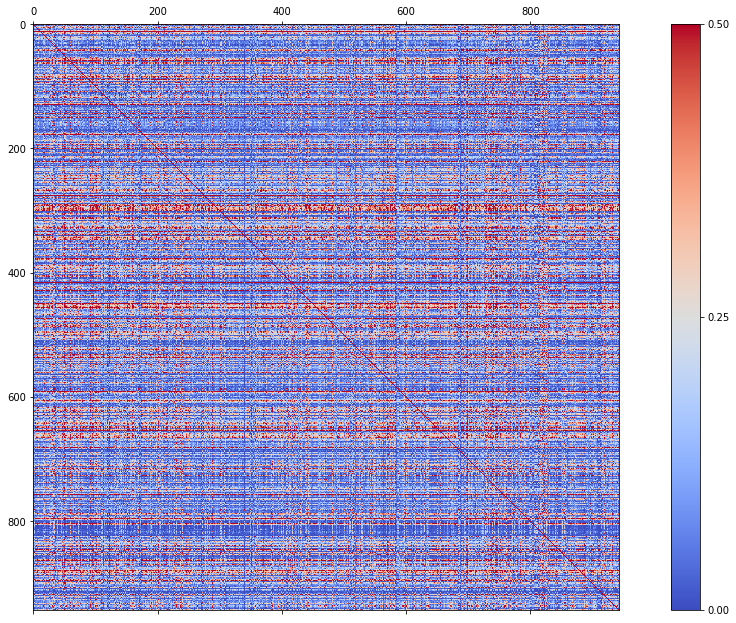

In [121]:
cax = plt.matshow(userSimilarity, fignum=1000, cmap=plt.cm.coolwarm)
plt.gcf().colorbar(cax, ticks=[0, 0.25, 0.5])
plt.clim(0, 0.5)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [122]:
np.mean(userSimilarity), np.std(userSimilarity)

(0.17710749461969763, 0.17505453892843229)

*Note that if we multiply `userSimilarity` by `uMatrixTraining` we get the ratings weigthed with user similar similarity. Then, we have to normalize by the average similarity for each user*

In [123]:
print(userSimilarity.shape, uMatrixTraining.shape)

(943, 943) (943, 1682)


In [124]:
#cada fila es un usuario
norm = np.array([userSimilarity.sum(axis=1)]).T
norm.shape

(943, 1)

In [125]:
userItemCFpredictions = userSimilarity.dot(uMatrixTraining) / norm

In [126]:
print(np.max(userItemCFpredictions),
      np.min(userItemCFpredictions),
      np.mean(userItemCFpredictions),
      np.std(userItemCFpredictions))

3.6059465609895747 0.0 0.1635708909699262 0.2752588119236399


*Note that some users might give generally lower ratings than others, so that we could have also corrected for this effect as follows*

In [127]:
sum_ = uMatrixTraining.sum(axis=1)
len_ =np.count_nonzero(uMatrixTraining, axis=1)
average_ratings = np.tile(sum_/ len_, n_items).reshape([n_items, n_users]).T

In [128]:
uMatrixTraining_shifted = uMatrixTraining - np.multiply(average_ratings, uMatrixTraining)

In [129]:
userItemCFpredictions_corrected = average_ratings + userSimilarity.dot(uMatrixTraining_shifted) / norm

In [130]:
# Now rating values are more reasonable
np.max(userItemCFpredictions_corrected), np.min(userItemCFpredictions_corrected), np.mean(userItemCFpredictions_corrected), np.std(userItemCFpredictions_corrected)

(4.928571428571429, -5.95653090571056, 3.1689829581780358, 0.8331334596743819)

### 4.2.2. Item-Item CF

*“Users who liked this movie also liked …”*

Consider item $i$:

1. For item $i$, find other similar items, i.e. calculate the similarity among items
2. Estimate rating for item $i$ based on ratings for similar items



In [136]:
# we use cosine similarity
itemSimilarity = cosineSimilarity(uMatrixTraining, kind='item')

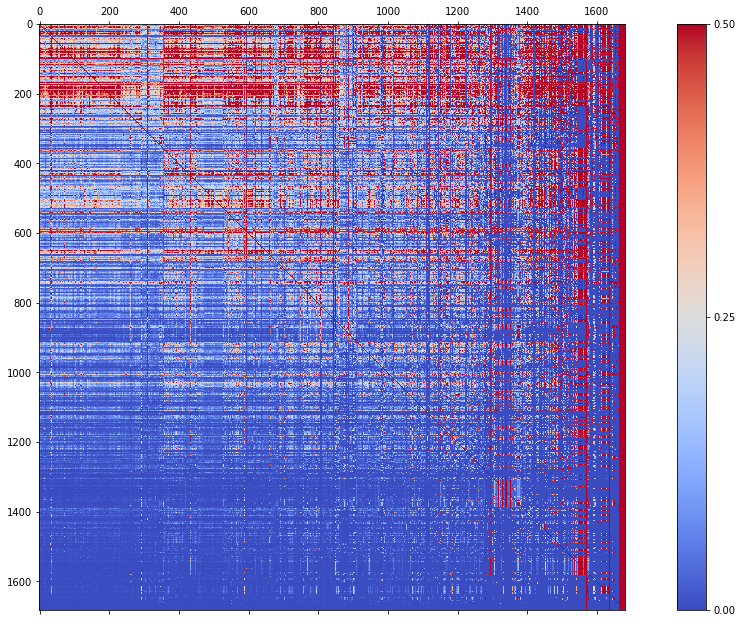

In [137]:
cax = plt.matshow(itemSimilarity, fignum=1000, cmap=plt.cm.coolwarm)
plt.gcf().colorbar(cax, ticks=[0, 0.25, 0.5])
plt.clim(0, 0.5)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

In [141]:
#itemItemCFpredictions 
itemItemCFpredictions = uMatrixTraining.dot(itemSimilarity) / np.array([np.abs(itemSimilarity).sum(axis=0)])

In [142]:
itemItemCFpredictions.shape

(943, 1682)

In [143]:
np.max(itemItemCFpredictions)

4.42903751937644

### 4.2.3 Show some recommendations

In case of item-item CF, the recommendation is pretty much the same as with the co-occurence matrix. It's also quite simple to find similar items to a given one.

<div class="alert alert-success">
Find movies similar to a given one using the item-item similarity matrix.
</div>

<div class="alert alert-success">
Calculate the recommendations obtained with the item-item CF model.
</div>

In [133]:
# Remove relevant items seen in train from our prediction:


<div class="alert alert-success">
Do the same with the user-user CF model.
</div>

**As you can see, the recommendations are pretty bad... Let's measure that**

### 4.2.4 Measure the recommendations

Since we are predicting ratings, it might make sense to introduce a metric that accounts for this. In particular, the **Root Mean Square Error (RMSE)** is typically used for this purpose. 

### $$\mathrm{RMSE}=\sqrt{\frac{1}{n_{\mathrm{users}}n_{\mathrm{items}}}\sum_{u,i}\left(r_{u,i}-\hat{r}_{u,i}\right)^2}$$

In [144]:
from math import sqrt
def rmse(prediction, ground_truth):
    """
    Return the Root Mean Squared Error of the prediction
    
    :param prediction: a 2-dim numpy array with the predictions
    :param ground_truth: a 2-dim numpy array with the known ratings
    
    :return the RMSE
    """
    r, c = ground_truth.nonzero()
    p = prediction[r, c]
    t = ground_truth[r, c]
    return sqrt(np.mean(np.power(p - t, 2.0)))

In [145]:
print('User-based CF RMSE=%.3f' %rmse(userItemCFpredictions, uMatrixTesting))

User-based CF RMSE=3.054


In [146]:
print('User-based (shifted) CF RMSE=%.3f' %rmse(userItemCFpredictions_corrected, uMatrixTesting))

User-based (shifted) CF RMSE=2.566


In [147]:
print('Item-based CF RMSE=%.3f' %rmse(itemItemCFpredictions, uMatrixTesting))

Item-based CF RMSE=2.633


<div class = "alert alert-danger">
**IMPORTANT TO NOTE**: RMSE was used in the RecSys community for many years to measure the accuracy 
of recommendations. However, it was demonstrated that high accuracy in predicting rating does not imply a good
ranked list!!    
</div>

### Calculate ranking metrics

In [148]:
userItemCFpredictions_sorted = np.argsort(userItemCFpredictions)[::-1]

In [153]:
# put together the rows of the test, train and predicted item ids. This can be done easily with the zip command.
# Be careful, though, because zip returns an iterable, so that it will dissapear once it's consumed. 
# To avoid this behavior, convert it to a list.
test_ids = testUsersGrouped.item_id.values
train_ids = trainUsersGrouped.item_id.values
predicted_ids = trainUsersGrouped.user_id.apply(lambda i: userItemCFpredictions_sorted[i-1]).values
zipped = list(zip(test_ids, train_ids, predicted_ids))

In [155]:
# Take a look at the zipped list
zipped[np.random.randint(n_users)]

([30, 59, 236, 268, 269, 272, 510],
 [99, 115, 126, 150, 236, 248, 252, 267, 273, 274, 407, 510, 1004],
 array([1681, 1664, 1680, ...,    0,   49,   99]))

<div class="alert alert-success">
As explained in class, the curse of dimensionality impedes us to obtain a good similarity measure among users or items (in this excercise, dimensions are ~1000; in a real Recommender Systems, they could be millions, billions or evene trillions!). This is the reason the above implementations do not work.
</div>

<a id='model-base'></a>
## 4.3. Model-based CF or Latent factor models
There are several model-based CF: from matrix factorizations to bayesian models, neural netwroks, etc. In all of them, we try to extract latent factors (vectors) that model user and item interactions. In contrast to previous methods, our hypothesis here is that the dimension of the latent spaces is rather small (in the order of a hundred dimensions). Then, we use this latent features to make a prediction:

## $$r_{u,i} \approx {\bf f}_u^T\cdot{\bf f}_i$$

The underlying assumption is that both users and items *live* in the same latent space, and that we can unravel such space. 

<img src="https://www.researchgate.net/profile/Tunca_Dogan/publication/235913413/figure/fig3/AS:299678856957952@1448460415040/Figure-3-The-distribution-of-the-points-in-the-Swiss-roll-dataset-in-3-D-space.png
" alt="swiss roll" style="float: center; width: 300px"/>


Here we will use a couple of linear Matrix Factorization (MF) models:

* Singular Value decomposition (SVD)
* Alternating Least Squares (ALS)

### 4.3.1 Singular value decomposition

The main idea is to reduce the dimensionality of the input space. This is pretty much the same as Eigen-decomposition or Principal Component Analysis (PCA)-

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/220px-GaussianScatterPCA.svg.png
" alt="dimensionaly reducion" style="float: center; width: 500px"/>


In [ ]:
from scipy.sparse.linalg import svds

In [ ]:
# look at the help!!!


In [ ]:
#get SVD components from train matrix. Choose k.


In [ ]:
# take a look at the different matrices


### Get the recommendations

We will reconstruct the utility matrix R (i.e., the recommendation matrix) as follows:

### $$M\approx U\mathrm{diag}(s)V^T$$

In [ ]:
# Build a diagonal matrix with the eigenvalues



In [ ]:
# make the prediction



In [ ]:
# check the dimensions are correct


### Evaluate the model

* RMSE
* Recall@30
* MAP@30

In [ ]:
#print('SVD RMSE=%.3f' % #TODO)

In [ ]:
# recall


In [ ]:
# Take a look at the zipped list


### Do the same with more dimensions

### Implicit vs Explicit feedback

In the above SVD matrix factorization we have tried to reconstructt the matrix of ratings. Howvever, it might be easier trying to model the matrix of preferences (i.e., wether the user likes or not a movie).

For this, we will define a “selector” matrix $I$ for the training utility matrix $R$, which will contain 0 if the rating matrix has no rating entry, and 1 if the rating matrix contains an entry. And the smae for testing data.


In [ ]:
# Index matrix for training data



In [ ]:
# Index matrix for test data



### Overfitting

As we introduce more dimensions in the model, we make it more prone to overfit. This can be observed in the decrease of error (RMSE) in train, while it increases in test.

In [ ]:
plt.semilogx(dims, error_train, '--*b', label="train")
plt.semilogx(dims, error_test, '--*g', label="test")
plt.xlabel("Numer of latent dimensions")
plt.ylabel("Error")
plt.legend(loc=7)
plt.show()

**Note that after few dimensions (~10) the model starts to overfit (the error in test increases). Thus, we need to use other method to regularize the model (i.e., set restrictions/limitations to the model, so that it cannot overfit)**

### 3.2 Alternating Least Squares (ALS)

SVD can be very slow and computationally expensive. Besides, when addressing only the relatively few known entries we are highly prone to overfitting.

An scalable alternative to SVD is ALS, which can include regularization terms to prevent overfitting. We will rename our variable to make them more similar to the ALS notation

### ALS algorithm

The ALS algorithm aims to estimate two unknown matrices which, when multiplied together, yield the rating matrix. The loss function you will use is the well-known sum of squared errors. The second term is for regularisation to prevent overfitting

<img src="https://latex.codecogs.com/gif.latex?\underset{Q*&space;,&space;P*}{min}\sum_{(u,i)\epsilon&space;K&space;}(r_{ui}-P_u^TQ_i)^2&plus;\lambda(\left&space;\|&space;Q_i&space;\right&space;\|^2&space;&plus;&space;\left&space;\|&space;P_u&space;\right&space;\|^2)$&space;&space;$" title="\underset{q* , p*}{min}\sum_{(u,i)\epsilon K }(r_{ui}-q_i^Tp_u)^2+\lambda(\left \| q_i \right \|^2 + \left \| p_u \right \|^2)" />

The Alternating Least Squares algorithm does this by first randomly filling the users matrix with values and then optimizing the value of the movies such that the error is minimized.  Then, it holds the movies matrix constant and optimizes the value of the user's matrix.  This alternation between which matrix to optimize is the reason for the "alternating" in the name. 

<img alt="factorization" src="http://spark-mooc.github.io/web-assets/images/matrix_factorization.png" style="width: 885px"/>
<br clear="all"/>

This optimization is what's being shown on the right in the image above.  Given a fixed set of user factors (i.e., values in the users matrix), we use the known ratings to find the best values for the movie factors using the optimization written at the bottom of the figure.  Then we "alternate" and pick the best user factors given fixed movie factors.

It must be noticed that this is another way of reducing the dimensionality of the input matrix (like PCA, or more generally, SVD). This has important consequences:

* ### Our decomposition is linear. We won't be able to catch non-linear relationships among users and items.
* ### As in PCA or SVD, our features will correspond to directions of maximum variance in the data. Thus, the first feature will catch most of this variation, the second, a little bit more, and so on. It implies that the error in the reconstruction will not decrease dramatically when using more features!!! Keep this in mind.


In [ ]:
def alsRmse(I,R,P,Q):
    return np.sqrt(np.sum((I * (R - np.dot(P,Q.T)))**2)/len(R[R > 0]))

In [ ]:
def iteration(user, fixed_vecs, counts, num_factors, reg_param, num_solve, verbose=False):
    num_fixed = fixed_vecs.shape[0]
    YTY = fixed_vecs.T.dot(fixed_vecs)
    eye = np.eye(num_fixed)
    lambda_eye = reg_param * np.eye(num_factors)
    solve_vecs = np.zeros((num_solve, num_factors))

    t = time.time()
    for i in range(num_solve):
        if user:
            counts_i = counts[i]
        else:
            counts_i = counts[:, i].T
        CuI = np.diag(counts_i)
        pu = counts_i.copy()
        pu[np.where(pu != 0)] = 1.0
        YTCuIY = fixed_vecs.T.dot(CuI).dot(fixed_vecs)
        YTCupu = fixed_vecs.T.dot(CuI + eye).dot(pu.T)
        xu = np.linalg.solve(YTY + YTCuIY + lambda_eye, YTCupu)
        solve_vecs[i] = xu
        if verbose and i % 300 == 0:
            print('Solved %i vecs in %d seconds' % (i, time.time() - t))
            t = time.time()

    return solve_vecs

In [ ]:
# Check performance by plotting train and test errors
def check_als_performance(n_epochs, train_errors, test_errors):
    plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
    plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
    plt.title('ALS-WR Learning Curve')
    plt.xlabel('Number of Epochs');
    plt.ylabel('RMSE');
    plt.ylim(1, 5)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# check als performance


### ALS evaluation
* RMSE
* recall@[5, 10, 20, 50, 100, 200, 500]
* map@[5, 10, 20, 50, 100, 200, 500]

In [ ]:


print('ALS CF RMSE: ' + str(rmse(alsPredictions, uMatrixTesting)))
print('SVD CF RMSE: ' + str(rmse(svdPredictions, uMatrixTesting)))

In [ ]:
# evalutation


<a id='exercises'></a>
## 4. Exercises (advanced)

<div class = "alert alert-success">
**E1:** Implement centered cosine similarity metric in [CF with co-occurrence](#copurchase)
</div>

<div class = "alert alert-success">
**E2:** Implement k-neighbors in [Memory-based CF](#memory-base)
</div>

<div class = "alert alert-success">
**E3:** Implement ALS with user and items biases, i.e.

$r_{ui}\approx P_u^T*Q_i+b_u+b_i$
</div>

<div class = "alert alert-success">
**E4:** Implement ALS in terms of implicit feedback (1s and 0s), instead of ratings.
</div>

Take a look at http://infolab.stanford.edu/~ullman/mmds/ch9.pdf